In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [3]:
X=np.load('data_X_with_callback.npy')
y=np.load('data_y_with_callback.npy')

In [4]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [6]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
for layer in model.layers:
    layer.trainable=False

x=model.output
x=layers.Flatten()(x)
x=Dense(4096, activation='relu')(x)
x=layers.BatchNormalization()(x)
outputs=Dense(4, activation='softmax')(x)

additional_model=Model(inputs=model.input, outputs=outputs)

additional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [9]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_fine_tuning.hdf5', 
            monitor='val_acc', 
            mode='max', 
            save_best_only=True)

In [10]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [11]:
class_weight = {0: 0.8,
                1: 1,
                2: 1,
                3: 1}

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=5, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/5
54/53 [==============================] - 18s 325ms/step - loss: 2.0654 - acc: 0.4767 - auc: 0.6973 - precision: 0.4509 - recall: 0.4127 - f1score: 0.1314 - val_loss: 2.5013 - val_acc: 0.2611 - val_auc: 0.7244 - val_precision: 0.4628 - val_recall: 0.4364 - val_f1score: 0.0865
Epoch 2/5
54/53 [==============================] - 14s 253ms/step - loss: 1.3567 - acc: 0.5524 - auc: 0.7380 - precision: 0.4775 - recall: 0.4488 - f1score: 0.1492 - val_loss: 1.4955 - val_acc: 0.4196 - val_auc: 0.7507 - val_precision: 0.4965 - val_recall: 0.4593 - val_f1score: 0.1233
Epoch 3/5
54/53 [==============================] - 14s 263ms/step - loss: 1.0474 - acc: 0.5956 - auc: 0.7625 - precision: 0.5147 - recall: 0.4723 - f1score: 0.1589 - val_loss: 1.6859 - val_acc: 0.4382 - val_auc: 0.7703 - val_precision: 0.5293 - val_recall: 0.4829 - val_f1score: 0.1212
Epoch 4/5
54/53 [==============================] - 14s 264ms/step - loss: 0.9052 - acc: 0.6253 - auc: 0.7782 - precision: 0.5429 - recall: 0.4

In [15]:
for layer in additional_model.layers[:11]:
    layer.trainable=False

for layer in additional_model.layers[11:]:
    layer.trainable=True

In [16]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x000001CD00F18188> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00F145C8> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00F14F88> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CD00F7B408> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00F7BC08> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00FC8708> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CD00FC8388> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00FCD508> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00FD1C08> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00FD9148> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CD00FE3D48> False
<keras.layers.convolutional.Conv2D object at 0x000001CD00FE35C8> True
<keras.layers.convolutional.Conv2D object at 0x000001CD00FEC048> True
<keras.layers.convolutional.Conv2D object at 0x000001CD00FF6608> True
<keras.

In [17]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [18]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=10, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/10
54/53 [==============================] - 16s 303ms/step - loss: 0.7809 - acc: 0.6533 - auc_1: 0.8882 - precision_1: 0.7157 - recall_1: 0.6044 - f1score: 0.1702 - val_loss: 1.1534 - val_acc: 0.5455 - val_auc_1: 0.8756 - val_precision_1: 0.6841 - val_recall_1: 0.5822 - val_f1score: 0.1479
Epoch 2/10
54/53 [==============================] - 14s 258ms/step - loss: 0.6722 - acc: 0.7080 - auc_1: 0.8808 - precision_1: 0.6932 - recall_1: 0.5925 - f1score: 0.1787 - val_loss: 1.2522 - val_acc: 0.5291 - val_auc_1: 0.8832 - val_precision_1: 0.6964 - val_recall_1: 0.6018 - val_f1score: 0.1490
Epoch 3/10
54/53 [==============================] - 15s 279ms/step - loss: 0.6333 - acc: 0.7051 - auc_1: 0.8869 - precision_1: 0.7022 - recall_1: 0.6056 - f1score: 0.1808 - val_loss: 1.0802 - val_acc: 0.5594 - val_auc_1: 0.8889 - val_precision_1: 0.7041 - val_recall_1: 0.6066 - val_f1score: 0.1563
Epoch 4/10
54/53 [==============================] - 14s 261ms/step - loss: 0.6253 - acc: 0.7174 - auc_1

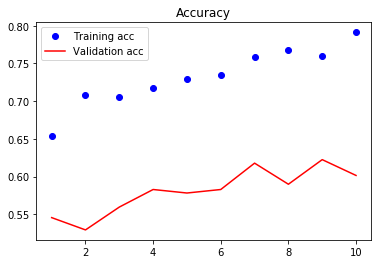

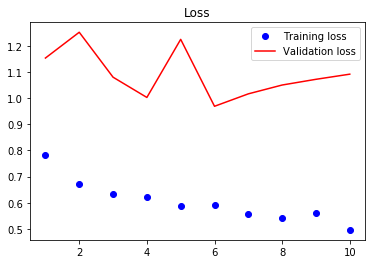

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [20]:
for layer in additional_model.layers:
    layer.trainable=True

In [21]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=30, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/30
54/53 [==============================] - 17s 324ms/step - loss: 0.4680 - acc: 0.7920 - auc: 0.9571 - precision_2: 0.8388 - recall_2: 0.7701 - f1score: 0.1982 - val_loss: 0.9687 - val_acc: 0.6084 - val_auc: 0.9454 - val_precision_2: 0.8087 - val_recall_2: 0.7428 - val_f1score: 0.1648
Epoch 2/30
54/53 [==============================] - 16s 290ms/step - loss: 0.4179 - acc: 0.8118 - auc: 0.9453 - precision_2: 0.8061 - recall_2: 0.7402 - f1score: 0.2014 - val_loss: 0.9557 - val_acc: 0.6177 - val_auc: 0.9458 - val_precision_2: 0.8049 - val_recall_2: 0.7401 - val_f1score: 0.1657
Epoch 3/30
54/53 [==============================] - 16s 292ms/step - loss: 0.4160 - acc: 0.8293 - auc: 0.9467 - precision_2: 0.8093 - recall_2: 0.7439 - f1score: 0.2025 - val_loss: 0.9594 - val_acc: 0.6410 - val_auc: 0.9463 - val_precision_2: 0.8106 - val_recall_2: 0.7444 - val_f1score: 0.1670
Epoch 4/30
54/53 [==============================] - 14s 265ms/step - loss: 0.4372 - acc: 0.8153 - auc: 0.9469 - pre

Epoch 29/30
54/53 [==============================] - 14s 264ms/step - loss: 0.3326 - acc: 0.8683 - auc: 0.9530 - precision_2: 0.8262 - recall_2: 0.7688 - f1score: 0.2116 - val_loss: 1.0034 - val_acc: 0.6410 - val_auc: 0.9530 - val_precision_2: 0.8262 - val_recall_2: 0.7690 - val_f1score: 0.1673
Epoch 30/30
54/53 [==============================] - 15s 284ms/step - loss: 0.3336 - acc: 0.8671 - auc: 0.9532 - precision_2: 0.8266 - recall_2: 0.7697 - f1score: 0.2123 - val_loss: 1.0026 - val_acc: 0.6317 - val_auc: 0.9532 - val_precision_2: 0.8268 - val_recall_2: 0.7701 - val_f1score: 0.1669


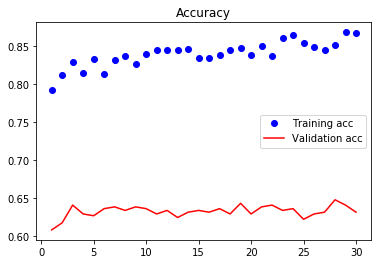

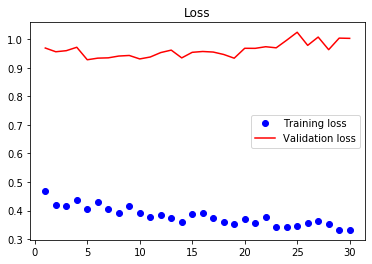

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [23]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

429/429 [==============================] - 1s 3ms/step
loss: 1.003, accuracy: 0.632, auc: 0.953, precision: 0.826, recall: 0.769, f1score: 0.167


In [24]:
from sklearn.metrics import roc_auc_score

y_pred = additional_model.predict(X_val)
roc_auc_score(y_val, y_pred)

0.8719178358884394

In [25]:
new_model = models.load_model('VGG16_fine_tuning.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [26]:
X_test=np.load('X_val_with_callback.npy')
y_test=np.load('y_val_with_callback.npy')

In [27]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

716/716 [==============================] - 3s 4ms/step
loss: 0.973, accuracy: 0.627, auc: 0.872, precision: 0.639, recall: 0.599, f1score: 0.169
